In [15]:
# Import all the packages:
from bzrs_main.modules.ml_models.topo_bert.model_trainer import *
from bzrs_main.modules.ml_models.topo_bert.dataset_process import *
from bzrs_main.modules.ml_models.topo_bert.backbone_models import *
from bzrs_main.modules.ml_models.topo_bert.topo_bert import *
from bzrs_main.modules.ml_models.topo_bert.app_main import *
import pandas as pd
import PRJ_PATH
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)


In [25]:
# Data preparation:
exp_train_config = {
        '--task_name': 'bert_geoparsing',
        '--toponym_only': False,
        '--random_seed': 42,
        '--use_gpu': 1,
        '--train_data_type': 'conll',
        '--validate_data_type': 'conll',
        '--test_data_type': 'conll',
        '--train_data_dir': 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\',
        '--validate_data_dir': 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\',
        '--test_data_dir': 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\',
        '--train_data_file': 'train.txt',
        '--validate_data_file': 'test.txt',
        '--test_data_file': 'test.txt',
        '--is_validate': 1,
        '--is_test': 1,
        '--output_dir': './outputs',
        '--cache_dir': './cache',
        '--bert_model': 'bert-base-cased',
        '--do_lower_case': False,
        '--max_seq_length': 128,
        '--training_epoch': 2,
        '--train_batch_size': 4,
        '--test_batch_size': 4,
        '--learning_rate': 5e-5,
        '--warm_up_proportion': 0.1,
        '--weight_decay': 0.01,
        '--adam_epsilon': 1e-8,
        '--max_grad_norm': 1.0,
        '--num_grad_accum_steps': 1,
        '--loss_scale': 0
    }

# Get and combine dataset for only locations:
conll_train_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\'
conll_train_file = 'train.txt'
conll_test_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\'
conll_test_file = 'test.txt'
conll_valide_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\'
conll_valid_file = 'valid.txt'
wiki_train_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\Wikipedia3000\\'
wiki_train_file = 'Wikipedia3000_feature_added.txt'
wnut_train_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\WNUT2017\\'
wnut_train_file = 'WNUT2017_feature_added.txt'
harvey_test_dir = 'E:\\CodingProjects\\GRITFramework\\BZResearchStack\\src\\bzrs_main\\modules\\ml_models\\topo_bert\\datasets\\HarveyTweet2017\\'

# Prepare customized datasets:
data_processors_conll = Processor_CoNLL2003()
data_processors_standard = Processor_Standard_V1()
data_processors_harvey = Processor_Harvey()

total_train_examples_loc = []
total_train_examples_ner = []

conll_train_example_loc = data_processors_conll.get_train_data(conll_train_dir, conll_train_file, True)
wiki_train_example_loc = data_processors_standard.get_train_data(wiki_train_dir, wiki_train_file, True)
wnut_train_example_loc = data_processors_standard.get_train_data(wnut_train_dir, wnut_train_file, True)

conll_train_example_ner = data_processors_conll.get_train_data(conll_train_dir, conll_train_file)
wiki_train_example_ner = data_processors_standard.get_train_data(wiki_train_dir, wiki_train_file)
wnut_train_example_ner = data_processors_standard.get_train_data(wnut_train_dir, wnut_train_file)

conll_test_example_loc = data_processors_conll.get_test_data(conll_test_dir, conll_test_file, True)
conll_test_example_ner = data_processors_conll.get_test_data(conll_test_dir, conll_test_file)
conll_validate_example_ner = data_processors_conll.get_dev_data(conll_valide_dir, conll_valid_file)
harvey_test_example = data_processors_harvey.get_test_data(harvey_test_dir)


In [21]:
# Function of counting data and store to dataframe for visualization:
def get_plot_df(data_example):
    zero_count = 0
    loc_count = 0
    org_count = 0
    per_count = 0
    misc_count = 0
    other_count = 0
    data_count_pd = pd.DataFrame()
    for data in data_example:
        for element in data.label:
            if element == 'O':
                data_series = pd.Series({'data': 0,
                                         'type': 'O',
                                         'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                zero_count += 1
            elif element == 'B-LOC' or element == 'I-LOC':
                data_series = pd.Series({'data': 1,
                                        'type': 'LOC',
                                        'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                loc_count += 1
            elif element == 'B-ORG' or element == 'I-ORG':
                data_series = pd.Series({'data': 2,
                                        'type': 'ORG',
                                        'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                org_count += 1
            elif element == 'B-PER' or element == 'I-PER':
                data_series = pd.Series({'data': 3,
                                        'type': 'PER',
                                        'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                per_count += 1
            elif element == 'B-MISC' or element == 'I-MISC':
                data_series = pd.Series({'data': 4,
                                        'type': 'MISC',
                                        'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                misc_count += 1
            else:
                data_series = pd.Series({'data': 5,
                                        'type': 'OTHER',
                                        'org_type': element})
                data_count_pd = data_count_pd.append(data_series, ignore_index=True)
                other_count += 1
    # Print part of the results:
    print(f'Label 0 : {zero_count} \n '
          f'Label LOC: {loc_count} \n'
          f'Label ORG: {org_count} \n'
          f'Label PER: {per_count} \n'
          f'Label MISC: {misc_count} \n'
          f'Label OTHER: {other_count} \n')
    print(data_count_pd.head())

    # Return
    return data_count_pd

In [22]:
# Count for harvey dataset:
pd_data_count_harvey = get_plot_df(harvey_test_example)

Label 0 : 15295 
 Label LOC: 3973 
Label ORG: 0 
Label PER: 0 
Label MISC: 0 
Label OTHER: 0 

   data type org_type
0   1.0  LOC    B-LOC
1   0.0    O        O
2   0.0    O        O
3   0.0    O        O
4   0.0    O        O


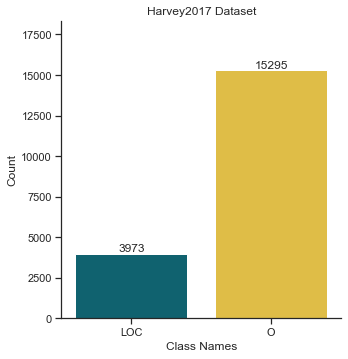

In [26]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']

# Plot for Harvey dataset:
catplot_harvey = sns.catplot(x="type", kind="count", data=pd_data_count_harvey, palette=palette_list)
catplot_harvey.set_xlabels('Class Names', fontsize=12)
catplot_harvey.set_ylabels('Count', fontsize=12)
catplot_harvey.set(title='Harvey2017 Dataset')
# iterate through axes and add labels:
for ax in catplot_harvey.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [27]:
# Count for conll train dataset:
pd_data_count_conll_train = get_plot_df(conll_train_example_ner)


Label 0 : 169578 
 Label LOC: 8297 
Label ORG: 10025 
Label PER: 11128 
Label MISC: 4593 
Label OTHER: 0 

   data  type org_type
0   2.0   ORG    B-ORG
1   0.0     O        O
2   4.0  MISC   B-MISC
3   0.0     O        O
4   0.0     O        O


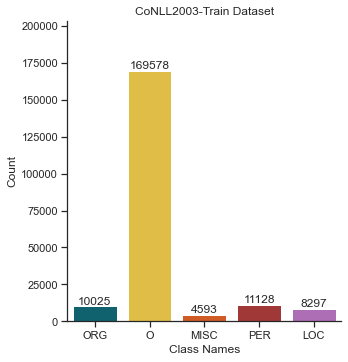

In [28]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']
# Plot for Harvey dataset:
catplot_conll_train = sns.catplot(x="type", kind="count", data=pd_data_count_conll_train, palette=palette_list)
catplot_conll_train.set_xlabels('Class Names', fontsize=12)
catplot_conll_train.set_ylabels('Count', fontsize=12)
catplot_conll_train.set(title='CoNLL2003-Train Dataset')
# iterate through axes and add labels:
for ax in catplot_conll_train.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [29]:
# Count for conll validation dataset:
pd_data_count_conll_validate = get_plot_df(conll_validate_example_ner)


Label 0 : 42759 
 Label LOC: 2094 
Label ORG: 2092 
Label PER: 3149 
Label MISC: 1268 
Label OTHER: 0 

   data type org_type
0   0.0    O        O
1   0.0    O        O
2   2.0  ORG    B-ORG
3   0.0    O        O
4   0.0    O        O


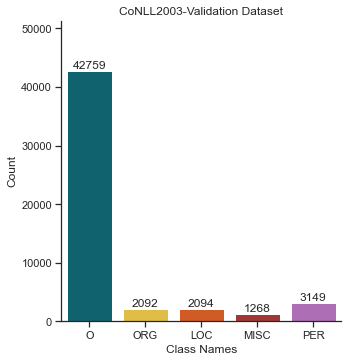

In [30]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']
# Plot for Harvey dataset:
catplot_conll_valid = sns.catplot(x="type", kind="count", data=pd_data_count_conll_validate, palette=palette_list)
catplot_conll_valid.set_xlabels('Class Names', fontsize=12)
catplot_conll_valid.set_ylabels('Count', fontsize=12)
catplot_conll_valid.set(title='CoNLL2003-Validation Dataset')
# iterate through axes and add labels:
for ax in catplot_conll_valid.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [31]:
# Count for conll test dataset:
pd_data_count_conll_test = get_plot_df(conll_test_example_ner)


Label 0 : 38323 
 Label LOC: 1925 
Label ORG: 2496 
Label PER: 2773 
Label MISC: 918 
Label OTHER: 0 

   data type org_type
0   0.0    O        O
1   0.0    O        O
2   1.0  LOC    B-LOC
3   0.0    O        O
4   0.0    O        O


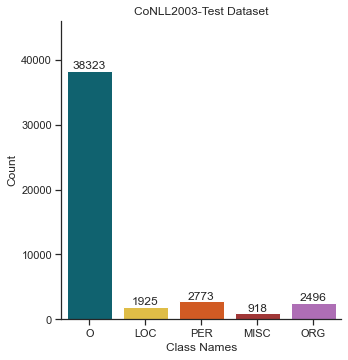

In [32]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']
# Plot for Harvey dataset:
catplot_conll_test = sns.catplot(x="type", kind="count", data=pd_data_count_conll_test, palette=palette_list)
catplot_conll_test.set_xlabels('Class Names', fontsize=12)
catplot_conll_test.set_ylabels('Count', fontsize=12)
catplot_conll_test.set(title='CoNLL2003-Test Dataset')
# iterate through axes and add labels:
for ax in catplot_conll_test.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [33]:
# Count for wiki3000 train dataset:
pd_data_count_wiki = get_plot_df(wiki_train_example_ner)


Label 0 : 40466 
 Label LOC: 16000 
Label ORG: 0 
Label PER: 0 
Label MISC: 0 
Label OTHER: 0 

   data type org_type
0   1.0  LOC    B-LOC
1   1.0  LOC    I-LOC
2   0.0    O        O
3   0.0    O        O
4   0.0    O        O


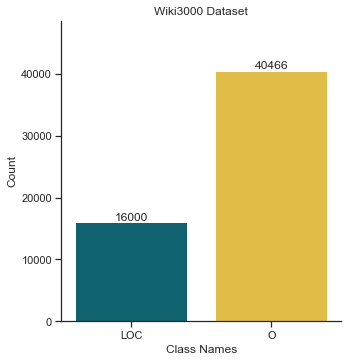

In [34]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']
# Plot for Harvey dataset:
catplot_wiki= sns.catplot(x="type", kind="count", data=pd_data_count_wiki, palette=palette_list)
catplot_wiki.set_xlabels('Class Names', fontsize=12)
catplot_wiki.set_ylabels('Count', fontsize=12)
catplot_wiki.set(title='Wiki3000 Dataset')
# iterate through axes and add labels:
for ax in catplot_wiki.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [35]:
# Count for WNUT dataset:
pd_data_count_wnut = get_plot_df(wnut_train_example_ner)


Label 0 : 10673 
 Label LOC: 1140 
Label ORG: 0 
Label PER: 0 
Label MISC: 0 
Label OTHER: 0 

   data type org_type
0   0.0    O        O
1   0.0    O        O
2   0.0    O        O
3   0.0    O        O
4   0.0    O        O


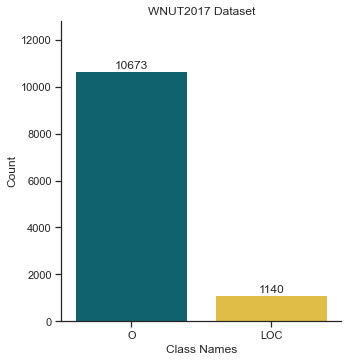

In [36]:
# Viz:
# Define bar colors:
palette_list = ["#006E7F", '#F8CB2E', '#EE5007', '#B22727', '#B762C1']
# Plot for Harvey dataset:
catplot_wnut = sns.catplot(x="type", kind="count", data=pd_data_count_wnut, palette=palette_list)
catplot_wnut.set_xlabels('Class Names', fontsize=12)
catplot_wnut.set_ylabels('Count', fontsize=12)
catplot_wnut.set(title='WNUT2017 Dataset')
# iterate through axes and add labels:
for ax in catplot_wnut.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)